# Weak-scaling benchmark on Leonardo and Miyabi

## Leonardo Architecture
- [https://wiki.u-gov.it/confluence/display/SCAIUS/LEONARDO+User+Guide#LEONARDOUserGuide-HardwareDetails]
- Compute node (CPU): Intel Ice Lake CPU (Intel Xeon Platinum 8358, 32 cores, 2.60GHz, TDP 250W) × 1 sockets
- Compute node (GPU): NVIDIA Ampere GPUs/node, 64GB HBM2e NVLink 3.0 (200GB/s) × 4
- Memory: 512 (8x64) GB DDR4 3200 MHz
- Interconnect: DragonFly+ 200 Gbps (NVIDIA Mellanox Infiniband HDR), dual port HDR100 per node × 2

## Installation commands on Leonardo
```
module purge
module load gcc/12.2.0
module load openmpi/4.1.6--gcc--12.2.0
module load python/3.11.6--gcc--12.2.0-nlkgjki
module load py-mpi4py/3.1.4--openmpi--4.1.6--gcc--12.2.0

python -m pip cache purge
python -m pip install jax[cuda12]
python -m pip install jaxlib[cuda12]
python -m pip install wheel cython
python -m pip install mpi4jax --no-build-isolation

git clone https://github.com/kousuke-nakano/jQMC.git # one needs a permission. Let us know your github account.
cd jQMC
python -m pip install -e .
```

# Miyabi Architecture
- Miyabi-G [https://www.cc.u-tokyo.ac.jp/supercomputer/miyabi/system.php]
- Compute node (CPU): NVIDIA Grace CPU (72 cores, 3.0 GHz) × 1 socket
- CPU Memory: 120 GB
- Compute node (GPU): NVIDIA Hopper H100 GPU (96 GB) × 4
- Interconnect: InfiniBand NDR (200Gbps)

## Installation commands on Miyabi
```python
module purge
module load python/3.10.16
module load gcc/11.4.1
module load ompi/4.1.6 

pip cache purge
pip install mpi4py
pip install jax[cuda12] jaxlib[cuda12] # they install cuda 12.3 and cudnn 9.1.
pip install wheel cython
pip install mpi4jax --no-build-isolation

git clone https://github.com/kousuke-nakano/jQMC.git # one needs a permission. Let us know your github account.
cd jQMC
git checkout 4b0969f01cf7c709a5b52074457629d34721a290
pip install -e .
```

In [1]:
%matplotlib inline

In [2]:
import os, sys
import glob
import re
import math
import time
import numpy as np
from uncertainties import unumpy as unp
import uncertainties.umath as umath
import matplotlib.pyplot as plt
import pandas as pd
from uncertainties import ufloat
from matplotlib.ticker import FuncFormatter

In [3]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [4]:
# unit conversion
# 1 Ha = 4.3597482*e-18 J
# 1 angstrom = 1.0*10e-10 m
# 1 atomic unit = 1.66057*10e-27 kg
# 1 THz = 33.35641 cm-1
Ry_to_J = 2.17987 * 10**-18
Ha_to_J = Ry_to_J * 2.0
J_to_Ha = 1.0 / Ha_to_J
aumass_to_kg = 1.66054 * 10**-27
bohr_to_m = 5.29177210903 * 10**-11
bohr_to_ang = 0.529177210903
ang_to_bohr = 1.0 / bohr_to_ang
m_to_bohr = 1.0 / bohr_to_m
au_to_GPa = (4.359e-18) / (0.5291772e-10) ** 3 * (10**-9)
KBar_to_Ha_bohr = 10**8 * J_to_Ha / (m_to_bohr) ** 3
Ha_bohr_to_KBar = 1.0 / KBar_to_Ha_bohr
# au_to_GPa = 1 a.u. = 1 Hartree/(1 Bohr)^3 = (4.359e-18 J)/(0.5291772e-10 m)^3 * (10**-12)

In [5]:
import ipynb_path

root_dir = os.path.dirname(ipynb_path.get())
os.chdir(root_dir)
root_dir

'/Users/kosuke/applications/jQMC/examples/example07'

In [6]:
# def read
def read_lrdmc_elapsed_time(file):
    with open(file, "r") as f:
        lines = f.readlines()
        for line in lines:
            if re.match(".*Net.*GFMC.*time.*without.*pre-compilations.*", line):
                elapsed_time = float(line.split()[6])
                return elapsed_time
        print(file)
        return np.nan

In [7]:
# def read
def read_lrdmc_num_branching(file):
    with open(file, "r") as f:
        lines = f.readlines()
        for line in lines:
            if re.match("Total.*GFMC.*time.*for.*", line):
                num_branching = int(line.split()[4])
                return num_branching
        print(file)
        return np.nan

In [8]:
# Leonardo
## parameters
node_list = [1, 2, 4, 8, 16, 32, 64, 128]
mpi_list = [4, 8, 16, 32, 64, 128, 256, 512]
mpi_per_node = 4
trial_num = 3

## input values
nw = 100

## files
out_lrdmc_gpu = "out_lrdmc_on_gpu"

## read data
lrdmc_elapsed_time_gpu_np = []
lrdmc_num_MPI_processes_gpu_np = []
lrdmc_num_nw_for_each_MPI_gpu_np = []
lrdmc_label_gpu_np = []

for node, mpi in zip(node_list, mpi_list):
    ## labels
    lrdmc_num_MPI_processes_gpu_np.append(mpi)
    lrdmc_num_nw_for_each_MPI_gpu_np.append(nw)
    lrdmc_label_gpu_np.append(f"({mpi}MPI, {nw}Nw)")

    ## dirs
    gpu_dirs = [
        os.path.join(root_dir, "leonardo", f"node_{node}_mpi_{mpi}_mpi_per_node_{mpi_per_node}_trial_{i_trial}")
        for i_trial in range(trial_num)
    ]

    ## LRDMC
    lrdmc_num_branching_gpu_np = np.array(
        [read_lrdmc_num_branching(os.path.join(gpu_dir, out_lrdmc_gpu)) for gpu_dir in gpu_dirs]
    )
    lrdmc_elapsed_time = np.array([read_lrdmc_elapsed_time(os.path.join(gpu_dir, out_lrdmc_gpu)) for gpu_dir in gpu_dirs])
    lrdmc_elapsed_time_gpu_np.append(np.mean(lrdmc_elapsed_time))

lrdmc_num_branching_gpu_np = np.array(lrdmc_num_branching_gpu_np)
lrdmc_elapsed_time_gpu_np = np.array(lrdmc_elapsed_time_gpu_np)
lrdmc_num_MPI_processes_gpu_np = np.array(lrdmc_num_MPI_processes_gpu_np)
lrdmc_num_nw_for_each_MPI_gpu_np = np.array(lrdmc_num_nw_for_each_MPI_gpu_np)
lrdmc_label_gpu_np = np.array(lrdmc_label_gpu_np)

leonardo_summary_lrdmc = {
    "lrdmc_num_branching_gpu_np": lrdmc_num_branching_gpu_np,
    "lrdmc_elapsed_time_gpu_np": lrdmc_elapsed_time_gpu_np,
    "lrdmc_num_MPI_processes_gpu_np": lrdmc_num_MPI_processes_gpu_np,
    "lrdmc_num_nw_for_each_MPI_gpu_np": lrdmc_num_nw_for_each_MPI_gpu_np,
    "lrdmc_label_gpu_np": lrdmc_label_gpu_np,
}

In [10]:
# Leonardo
## parameters
node_list = [1, 2, 4, 8, 16, 32, 64, 128]
mpi_list = [4, 8, 16, 32, 64, 128, 256, 512]
mpi_per_node = 4
trial_num = 3

## input values
nw = 100

## files
out_lrdmc_gpu = "out_lrdmc_tau_on_gpu"

## read data
lrdmc_elapsed_time_gpu_np = []
lrdmc_num_MPI_processes_gpu_np = []
lrdmc_num_nw_for_each_MPI_gpu_np = []
lrdmc_label_gpu_np = []

for node, mpi in zip(node_list, mpi_list):
    ## labels
    lrdmc_num_MPI_processes_gpu_np.append(mpi)
    lrdmc_num_nw_for_each_MPI_gpu_np.append(nw)
    lrdmc_label_gpu_np.append(f"({mpi}MPI, {nw}Nw)")

    ## dirs
    gpu_dirs = [
        os.path.join(root_dir, "leonardo", f"node_{node}_mpi_{mpi}_mpi_per_node_{mpi_per_node}_trial_{i_trial}")
        for i_trial in range(trial_num)
    ]

    ## LRDMC
    lrdmc_num_branching_gpu_np = np.array(
        [read_lrdmc_num_branching(os.path.join(gpu_dir, out_lrdmc_gpu)) for gpu_dir in gpu_dirs]
    )
    lrdmc_elapsed_time = np.array([read_lrdmc_elapsed_time(os.path.join(gpu_dir, out_lrdmc_gpu)) for gpu_dir in gpu_dirs])
    lrdmc_elapsed_time_gpu_np.append(np.mean(lrdmc_elapsed_time))

lrdmc_num_branching_gpu_np = np.array(lrdmc_num_branching_gpu_np)
lrdmc_elapsed_time_gpu_np = np.array(lrdmc_elapsed_time_gpu_np)
lrdmc_num_MPI_processes_gpu_np = np.array(lrdmc_num_MPI_processes_gpu_np)
lrdmc_num_nw_for_each_MPI_gpu_np = np.array(lrdmc_num_nw_for_each_MPI_gpu_np)
lrdmc_label_gpu_np = np.array(lrdmc_label_gpu_np)

leonardo_summary_lrdmc_tau = {
    "lrdmc_num_branching_gpu_np": lrdmc_num_branching_gpu_np,
    "lrdmc_elapsed_time_gpu_np": lrdmc_elapsed_time_gpu_np,
    "lrdmc_num_MPI_processes_gpu_np": lrdmc_num_MPI_processes_gpu_np,
    "lrdmc_num_nw_for_each_MPI_gpu_np": lrdmc_num_nw_for_each_MPI_gpu_np,
    "lrdmc_label_gpu_np": lrdmc_label_gpu_np,
}

speed_up = [1.17840819 1.18985433 1.20202617 1.2116776  1.22308046 1.22807097
 1.2372725  1.24126207]


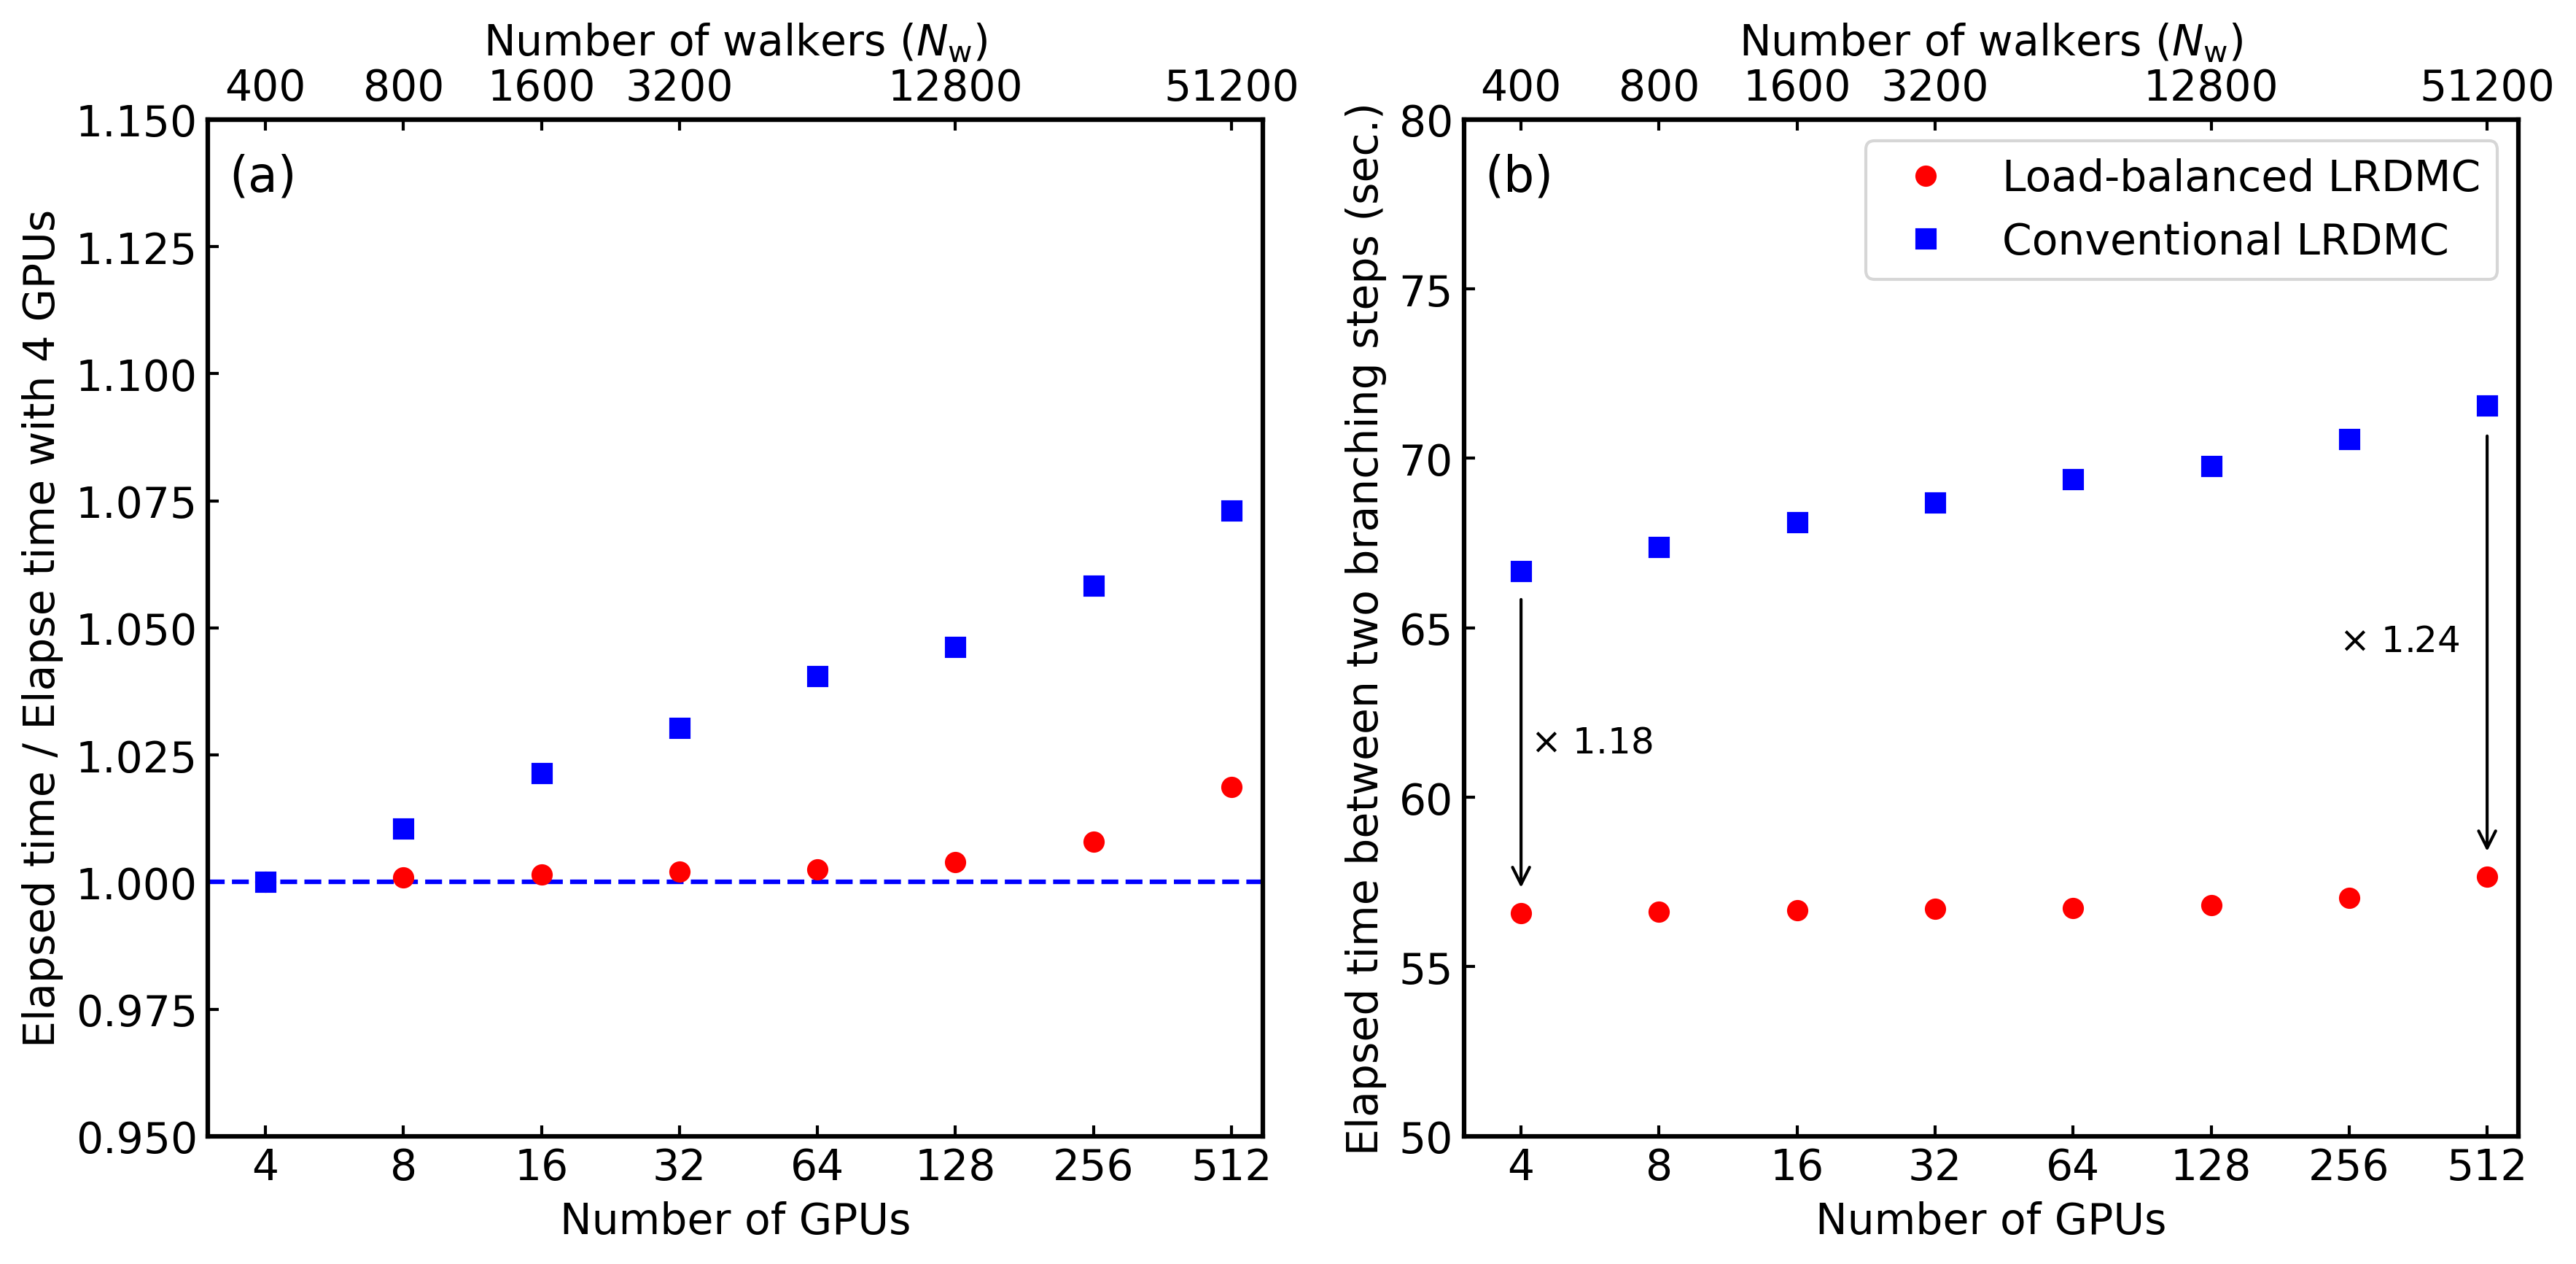

In [16]:
# plot Graph (GPU)
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.major.width"] = 1.0
plt.rcParams["ytick.major.width"] = 1.0
plt.rcParams["font.size"] = 14
plt.rcParams["axes.linewidth"] = 1.5

fig = plt.figure(figsize=(12, 6), facecolor="white", dpi=300, tight_layout=True)

# relative
ax1 = fig.add_subplot(1, 2, 1)
ax1.text(0.02, 0.93, "(a)", transform=ax1.transAxes, fontsize=16)

y_min = 0.95
y_max = 1.15

# labels
ax1.set_xlabel("Number of GPUs")
ax1.set_ylabel(r"Elapsed time / Elapse time with 4 GPUs")

ax1.set_xscale("log")
ax1.set_xlim([3, 600])
ax1.set_ylim([y_min, y_max])

# ref
ax1.axhline(1.0, color="b", ls="--", label="Ideal")

# Leonardo
lrdmc_ref_index = list(leonardo_summary_lrdmc["lrdmc_num_MPI_processes_gpu_np"]).index(4)
x = leonardo_summary_lrdmc["lrdmc_num_MPI_processes_gpu_np"]
y = leonardo_summary_lrdmc["lrdmc_elapsed_time_gpu_np"] / leonardo_summary_lrdmc["lrdmc_elapsed_time_gpu_np"][lrdmc_ref_index]
ax1.plot(
    x,
    y,
    color="r",
    marker="o",
    markersize=6,
    ls="",
    alpha=1.0,
    label="Load-balanced LRDMC",
)

# Leonardo
lrdmc_ref_index = list(leonardo_summary_lrdmc_tau["lrdmc_num_MPI_processes_gpu_np"]).index(4)
x = leonardo_summary_lrdmc_tau["lrdmc_num_MPI_processes_gpu_np"]
y = (
    leonardo_summary_lrdmc_tau["lrdmc_elapsed_time_gpu_np"]
    / leonardo_summary_lrdmc_tau["lrdmc_elapsed_time_gpu_np"][lrdmc_ref_index]
)
ax1.plot(
    x,
    y,
    color="b",
    marker="s",
    markersize=6,
    ls="",
    alpha=1.0,
    label="Conventional LRDMC",
)

# mirror axis
factor = 100


def mpi_to_node(mpi):
    return mpi * factor


def node_to_mpi(node):
    return node / factor


primary_ticks = leonardo_summary_lrdmc["lrdmc_num_MPI_processes_gpu_np"]
ax1.set_xticks(primary_ticks)
ax1.set_xticklabels([str(t) for t in primary_ticks])
ax1.minorticks_off()

secax1 = ax1.secondary_xaxis("top", functions=(mpi_to_node, node_to_mpi))
secax1.set_xlabel(r"Number of walkers $(N_{\rm w}$)")

node_ticks = [mpi_to_node(mpi) for mpi in primary_ticks]
node_ticks = [t for t in node_ticks if t not in [6400, 25600]]
secax1.set_xticks(node_ticks)

secax1.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(round(x))}"))
secax1.minorticks_off()

# Absolute
ax2 = fig.add_subplot(1, 2, 2)
ax2.text(0.02, 0.93, "(b)", transform=ax2.transAxes, fontsize=16)

y_min = 50.0
y_max = 80.0

# labels
ax2.set_xlabel("Number of GPUs")
ax2.set_ylabel(r"Elapsed time between two branching steps (sec.)")

ax2.set_xscale("log")
ax2.set_xlim([3, 600])
ax2.set_ylim([y_min, y_max])

# Leonardo
x = leonardo_summary_lrdmc["lrdmc_num_MPI_processes_gpu_np"]
y = leonardo_summary_lrdmc["lrdmc_elapsed_time_gpu_np"] / np.unique(leonardo_summary_lrdmc["lrdmc_num_branching_gpu_np"])
x_load_balanced = x
y_load_balanced = y

ax2.plot(
    x,
    y,
    color="r",
    marker="o",
    markersize=6,
    ls="",
    alpha=1.0,
    label="Load-balanced LRDMC",
)

# Leonardo
x = leonardo_summary_lrdmc_tau["lrdmc_num_MPI_processes_gpu_np"]
y = leonardo_summary_lrdmc_tau["lrdmc_elapsed_time_gpu_np"] / np.unique(
    leonardo_summary_lrdmc_tau["lrdmc_num_branching_gpu_np"]
)
x_conventional = x
y_conventional = y
ax2.plot(
    x,
    y,
    color="b",
    marker="s",
    markersize=6,
    ls="",
    alpha=1.0,
    label="Conventional LRDMC",
)

# mirror axis
factor = 100


def mpi_to_node(mpi):
    return mpi * factor


def node_to_mpi(node):
    return node / factor


primary_ticks = leonardo_summary_lrdmc["lrdmc_num_MPI_processes_gpu_np"]
ax2.set_xticks(primary_ticks)
ax2.set_xticklabels([str(t) for t in primary_ticks])
ax2.minorticks_off()

secax2 = ax2.secondary_xaxis("top", functions=(mpi_to_node, node_to_mpi))
secax2.set_xlabel(r"Number of walkers $(N_{\rm w}$)")

node_ticks = [mpi_to_node(mpi) for mpi in primary_ticks]
node_ticks = [t for t in node_ticks if t not in [6400, 25600]]
secax2.set_xticks(node_ticks)

secax2.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(round(x))}"))
secax2.minorticks_off()

# speed-up
speed_up = y_conventional / y_load_balanced
print(f"speed_up = {speed_up}")

# annotation
i = 0  # N_w = 400
ax2.annotate(
    "",
    xy=(x_load_balanced[i], y_load_balanced[i] * 1.01),
    xytext=(x_conventional[i], y_conventional[i] * 0.99),
    arrowprops=dict(arrowstyle="->", color="k", lw=1),
)
ax2.text(
    x_load_balanced[i] * 1.05,
    (y_conventional[i] - y_load_balanced[i]) * 0.5 + y_load_balanced[i],
    rf"$\times$ {speed_up[i]:.2f}",
    va="center",
    fontsize=12,
    color="k",
)

i = 7  # N_w = 51200
ax2.annotate(
    "",
    xy=(x_load_balanced[i], y_load_balanced[i] * 1.01),
    xytext=(x_conventional[i], y_conventional[i] * 0.99),
    arrowprops=dict(arrowstyle="->", color="k", lw=1),
)
ax2.text(
    x_load_balanced[i] / 2 * 0.95,
    (y_conventional[i] - y_load_balanced[i]) * 0.5 + y_load_balanced[i],
    rf"$\times$ {speed_up[i]:.2f}",
    va="center",
    fontsize=12,
    color="k",
)

plt.legend()
plt.savefig(f"jqmc_tau_nbra_comparison_benzene_on_gpu_leonardo.jpg")
plt.show()